# Preprocess LULC patches

- Query from Ohsome API
- Preprocess LULC patches
- Unify LULC patches to LULC classes
- Explore LULC patches amd classes
- Save LULC patches and classes  as feather files

In [1]:
import sys
import yaml
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from ohsome import OhsomeClient

datetime = '2024-03-15T00:00:00Z'

data_dir = Path('../data')
ca_lulc_dir = Path('../lulc-utility')
out_dir = Path('../outdir')

## Area of Interest

In [8]:
aoi_gdf = gpd.read_file(data_dir / 'MA-HD-RNK.geojson')
aoi_bpoly = aoi_gdf.to_json()

## LULC classes

### LULC tags

In [9]:
with open(ca_lulc_dir / 'data' / 'label' / 'label_v3.yaml') as file:
    osm_filters = yaml.safe_load(file)

In [10]:
osm_filters

[{'name': 'built-up',
  'osm_filter': 'landuse=civic_admin or landuse=commercial or landuse=depot or landuse=education or landuse=farmyard or landuse=garages or landuse=industrial or landuse=railway or landuse=residential or landuse=retail',
  'color_code': '#ff0000',
  'description': 'This class is a combination of land-use classes that should consist of mostly built-up land cover.'},
 {'name': 'forest',
  'osm_filter': 'landuse=forest or natural=wood',
  'color_code': '#4dc800',
  'description': 'Managed and unmanaged tree covers.'},
 {'name': 'water',
  'osm_filter': 'landuse=reservoir or natural=water or waterway=dock or waterway=riverbank',
  'color_code': '#82c8fa',
  'description': None},
 {'name': 'farmland',
  'osm_filter': 'landuse=farmland',
  'color_code': '#ffff50',
  'description': 'Agricultural land that is regularly tilled.'},
 {'name': 'permanent_crops',
  'osm_filter': 'landuse=vineyard or landuse=orchard',
  'color_code': '#e68000',
  'description': None},
 {'name': 

Iterate through the OSM filters and query the according LULC polygons

In [11]:
client = OhsomeClient()

responses = []
total = len(osm_filters)

try:
    for tag_i, tag_dict in zip(range(total + 1), osm_filters):
        print(f'Processing {tag_dict["name"]} ({tag_i + 1}/{total})...')
        response = client.elements.geometry.post(
            bpolys = aoi_bpoly, 
            filter = tag_dict['osm_filter'] + ' and geometry:polygon',
            time = datetime,
            properties = 'tags'
        )
        results_gdf = response.as_dataframe()
        results_gdf['lulc'] = tag_dict['name']
        responses.append(results_gdf)
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

Processing built-up (1/6)...
Processing forest (2/6)...
Processing water (3/6)...
Processing farmland (4/6)...
Processing permanent_crops (5/6)...
Processing grass (6/6)...


In [29]:
lulc_gdf = pd.concat(responses)

### Preprocess LULC and export

Cleanup GeoDataFrame, retain only LULC and geometry columns (polygons) and reproject

In [33]:
cols_to_keep = ['geometry', 'landuse', 'natural', 'waterway', 'lulc']
cols_to_drop = [col for col in lulc_gdf.columns if col not in cols_to_keep]
lulc_gdf.drop(columns=cols_to_drop, inplace=True)

lulc_gdf = lulc_gdf[lulc_gdf['geometry'].astype(object).apply(lambda geom: isinstance(geom, (Polygon, MultiPolygon)))]

lulc_gdf.columns, len(lulc_gdf)

(Index(['geometry', 'landuse', 'waterway', 'lulc', 'natural'], dtype='object'),
 32410)

### Unify LULC classes

In [34]:
lulc_union = lulc_gdf.dissolve(by='lulc').reset_index()

In [ ]:
lulc_union.drop(columns=['landuse', 'natural', 'waterway'], inplace=True)

## Explore files

In [35]:
pd.concat([lulc_gdf['lulc'].value_counts(), lulc_gdf['landuse'].value_counts(), lulc_gdf['natural'].value_counts()], axis=1, keys=['lulc', 'landuse', 'natural']).sort_index()

,lulc,landuse,natural
aquaculture,NaN,18.0,NaN
basin,NaN,2.0,NaN
built-up,2616.0,NaN,NaN
civic_admin,NaN,1.0,NaN
commercial,NaN,336.0,NaN
education,NaN,20.0,NaN
farmland,8218.0,8218.0,NaN
farmyard,NaN,659.0,NaN
forest,3189.0,1107.0,NaN
garages,NaN,38.0,NaN


### Verify LULC

In [3]:
lulc_union['lulc'].value_counts()

lulc
built-up           1
farmland           1
forest             1
grass              1
permanent_crops    1
water              1
Name: count, dtype: int64

In [4]:
colors = {
    'built-up': '#ff0000',
    'farmland': '#ffff50',
    'forest': '#4dc800',
    'grass': '#cdebb0',
    'permanent_crops': '#e68000',
    'water': '#82c8fa'
}

lulc_union['color'] = lulc_union['lulc'].map(colors)

<Figure size 1000x1000 with 0 Axes>

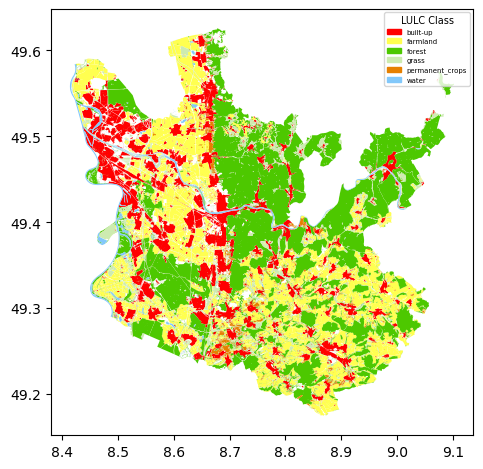

In [5]:
import matplotlib.patches as mpatches

# Create a patch for each class
patches = [mpatches.Patch(color=color, label=class_) for class_, color in colors.items()]

plt.figure(figsize=(25, 25))

lulc_union.plot(color=lulc_union['color'])

# Add the custom legend
plt.legend(handles=patches, loc='upper right', title='LULC Class', fontsize=5, title_fontsize=7)

# plt.savefig(out_dir / 'lulc.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Export files as feather files

LULC

In [ ]:
lulc_gdf.drop(columns=['lulc'], inplace=True)

In [38]:
lulc_gdf.to_feather(out_dir / 'preprocessed_lulc.feather')

LULC union

In [39]:
lulc_union.to_feather(out_dir / 'preprocessed_lulc_union.feather')